In [361]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

df1 = pd.read_csv('resources/transactions_1_tmp.csv')
df2 = pd.read_csv('resources/transactions_2_tmp.csv')

In [382]:
from prophet import Prophet

df1['time'] = pd.to_datetime(df1['time'], format='%H:%M')
df2['time'] = pd.to_datetime(df2['time'], format='%H:%M')

df1 = df1.loc[(df1['status'] == 'reversed') | (df1['status'] == 'failed') | (df1['status'] == 'denied')]
df2 = df2.loc[(df2['status'] == 'reversed') | (df2['status'] == 'failed') | (df2['status'] == 'denied')]

df3 = pd.concat([df1, df2])

In [ ]:
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
df3 = df3.set_index('timestamp').resample('H').mean()

df3 = df3.reset_index()
df3 = df3[['timestamp', 'count']].rename({'timestamp':'ds', 'count':'y'}, axis='columns')
df3 = df3[df3['ds'].notna()]


In [384]:
test = df3[(df3['ds'] >= '2022-11-01') & (df3['ds'] < '2022-11-02')]
train = df3[(df3['ds'] >= '2022-11-02')]

In [385]:
test.shape

(24, 2)

In [386]:
train.shape

(24, 2)

In [387]:
m = Prophet(changepoint_range=0.95)

In [388]:
m.fit(train)

15:00:33 - cmdstanpy - INFO - Chain [1] start processing
15:00:33 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=24, freq='H')
future.tail(48)

In [390]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43,2022-11-03 19:00:00,30.610687,21.473525,40.310986
44,2022-11-03 20:00:00,31.202090,22.635267,39.489994
45,2022-11-03 21:00:00,31.793493,22.497424,40.919865
46,2022-11-03 22:00:00,32.384896,23.530580,41.710059
47,2022-11-03 23:00:00,32.976299,23.998992,41.419237


In [391]:
results=pd.concat([train.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

In [ ]:
results

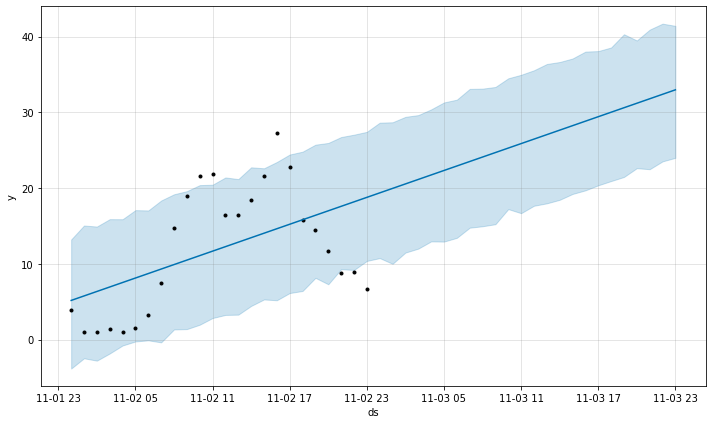

In [393]:
fig1 = m.plot(forecast)

In [ ]:
comp = m.plot_components(forecast)

In [ ]:
results

In [396]:
results['error'] = results['y'] - results['yhat']

In [397]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [ ]:
results